# Using Transition Matrix Methods and Jacobians with ConsMarkovModel

By Kenneth Eva (kjeeva@sas.upenn.edu) and William Du (wdu9@jhu.edu)

This Jupyter Notebook demonstrates how to non-stochastically simulate an economy with transition matrices and compute Jacobians for the ConsMarkovModel.

## Set Up

### Import Packages

In [27]:
import numpy as np
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from copy import deepcopy
import scipy.sparse as sp
import matplotlib.pyplot as plt

### Declare Dictionaries

In [28]:
# [ ] All parameters should have origin indicated

# First create a dictionary for an instance of an IndConsConsumer
DictIC = {
    # Parameters shared with the perfect foresight model
    "CRRA": 2,  # Coefficient of relative risk aversion
    "Rfree": 1.04**0.25,  # Interest factor on assets
    "DiscFac": 0.975,  # Intertemporal discount factor
    "LivPrb": 0.99375,  # Survival probability
    "PermGroFac": 1.0,  # Permanent income growth factor
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd": [0.06],  # Standard deviation of log permanent shocks to income
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkStd": [0.2],  # Standard deviation of log transitory shocks to income
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "UnempPrb": 0.00,  # Probability of unemployment while working
    "IncUnemp": 0.0,  # Unemployment benefits replacement rate
    "UnempPrbRet": 0.0000,  # Probability of "unemployment" while retired
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "T_retire": 0,  # Period of retirement (0 --> no retirement)

    # A few other parameters
    "BoroCnstArt": 0.0,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    # Parameters only used in simulation
    "AgentCount": 2000,  # Number of agents of this type
    "T_sim": 1000,  # Number of periods to simulate
    "aNrmInitMean": np.log(0.000001),  # Mean of log initial assets ,
    # The value of np.log(0.0) causes the code to ensure newborns have have exactly 1.0 in market resources.
    # Mean of log initial assets
    "aNrmInitStd": 0.0,  # Standard deviation of log initial assets
    "pLvlInitMean": 0.0,  # Mean of log initial permanent income
    "pLvlInitStd": 0.0,  # Standard deviation of log initial permanent income
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor
    "T_age": None,  # Age after which simulated agents are automatically killed
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin": 0.0001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 100000,  # Maximum end-of-period "assets above minimum" value
    "aXtraCount": 130,  # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac": 3,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra": None,  # Additional values to add to aXtraGrid
    # Parameters for Transition Matrix Simulation
    "mCount": 200,
    "mFac": 3,
    "mMin": 1e-4,
    "mMax": 10000,
    "MrkvArray": None,
    "MrkvPrbsInit": None,
}

# [ ] explain where these numbers come from as well
# Create a second dictionary for a ConsMarkovModel consumer
DictMrkv = deepcopy(DictIC)
DictMrkv["Rfree"] = np.array([1.04**0.25, 1.04**0.25, 1.04**0.25, 1.04**0.25])
DictMrkv["LivPrb"] = [np.array([0.99375, 0.99375, 0.99375, 0.99375])]
DictMrkv["PermGroFac"] = [np.array([1.0, 1.0, 1.0, 1.0])]
DictMrkv["MrkvArray"] = [np.array([[0.9, 0.1, 0.0, 0.0], \
                                   [0.7, 0.15, 0.15, 0], \
                                   [0.7, 0, 0.15, 0.15], \
                                   [0.7, 0, 0, 0.3]])]
DictMrkv["MrkvPrbsInit"] = np.array([0.99, 0.01, 0.0, 0.0])

# Length of all finite horizon exercises in this notebook
bigT = 100

### Create Instances of Agents and Income Shock Distributions

In [29]:
# Construct agent with above calibrations
agentIC = IndShockConsumerType(**DictIC)
agentMrkv = MarkovConsumerType(**DictMrkv)

# Set to infinite horizon
agentMrkv.cycles = 0

# Create employed, unemployed with benefits, and unemployted with no benefits
IncShkDstn_emp = deepcopy(agentIC.IncShkDstn[0])

# Create unemployment distributions from the employed distributions
# Calibration from HAFiscal
IncShkDstn_unemp = deepcopy(IncShkDstn_emp)
IncShkDstn_unemp.atoms[0] = IncShkDstn_unemp.atoms[0] * 0 + 1.0
IncShkDstn_unemp.atoms[1] = IncShkDstn_unemp.atoms[1] * 0 + 0.7

# Create unemployment no benefits, calibration from HAFiscal
IncShkDstn_unemp_nb = deepcopy(IncShkDstn_emp)
IncShkDstn_unemp_nb.atoms[0] = IncShkDstn_unemp_nb.atoms[0] * 0 + 1.0
IncShkDstn_unemp_nb.atoms[1] = IncShkDstn_unemp_nb.atoms[1] * 0 + 0.5

# Bundle together distributions for each state
IncShkDstn = [[IncShkDstn_emp, IncShkDstn_unemp, IncShkDstn_unemp, IncShkDstn_unemp_nb]]

## Simulation: Transition Matrix vs Monte Carlo

This section compares monte carlo methods against the transition matrix approach in computing aggregate assets.

### Method 1: Monte Carlo

In [30]:
# Simulate using Monte Carlo, takes about 3 minutes to run
agentMC = deepcopy(agentMrkv)
agentMC.IncShkDstn = deepcopy(IncShkDstn)
agentMC.solve()
agentMC.track_vars = ["aLvl"]
agentMC.initialize_sim()
agentMC.simulate()  
print("Monte Carlo aLvl average is:")
print(np.mean(agentMC.state_now["aLvl"]))

Monte Carlo aLvl average is:
0.4860851520268386


### Method 2: Transition Matrices

In [31]:
# Simulate using transition matrices, takes about 2 seconds to run
agentTM = deepcopy(agentMrkv)
agentTM.IncShkDstn = deepcopy(IncShkDstn)

agentTM.compute_steady_state(harmenberg = True)
print("Transition matrix aLvl average is:")
print(agentTM.A_ss)
print("...which should be close to the Monte Carlo result")

Transition matrix aLvl average is:
0.48969472947909687
...which should be close to the Monte Carlo result


### Comparing Steady State Outputs of Both Methods

In [32]:
print("TranMatrix Assets = " + str(agentTM.A_ss))
print("Simulated Assets = " + str(np.mean(agentMC.state_now["aLvl"])))

TranMatrix Assets = 0.48969472947909687
Simulated Assets = 0.4860851520268386


## Calculating Response to Perfect foresight MIT Shock

This section details an experiment to exhibit how to the transition matrix method can be utilized to compute the paths of aggregate consumption and aggregate assets given a pertubation in a variable for one period. In particular, in this experiment, in period t=0, agents learn that there will be a shock in the interest rate in period t=10. Given this, the simulated paths of aggregate consumption and aggregate assets will be computed and plotted.



In [33]:
# augment parameters to finite horizon exercise
params = deepcopy(DictMrkv)
params["T_cycle"] = bigT
params["LivPrb"] = params["T_cycle"] * [agentTM.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [agentTM.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [agentTM.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [agentTM.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [agentTM.Rfree]
params["MrkvArray"] = params["T_cycle"] * agentTM.MrkvArray

FinHorizonAgent = MarkovConsumerType(**params)
FinHorizonAgent.cycles = 1
FinHorizonAgent.IncShkDstn = deepcopy(IncShkDstn)
FinHorizonAgent.del_from_time_inv(
    "Rfree",
)
FinHorizonAgent.add_to_time_vary("Rfree")

FinHorizonAgent.IncShkDstn = params["T_cycle"] * [FinHorizonAgent.IncShkDstn[0]]
FinHorizonAgent.solution_terminal = deepcopy(agentTM.solution[0])
FinHorizonAgent.track_vars = ["cNrm", "pLvl", "aNrm"]

### Perturb Real Interest Rate

In [34]:
dx = 0.0001 # Change in the Interest Rate
i = 10  # Period in which the change in the interest rate occurs

FinHorizonAgent.Rfree = (
    (i) * [agentTM.Rfree] + [agentTM.Rfree + dx] + (params["T_cycle"] - i - 1) * [agentTM.Rfree]
)

FinHorizonAgent.solution_terminal = deepcopy(agentTM.solution[0])

### Calculate Transition Matrices with Neutral Measure (Harmenberg 2021)

In [35]:
FinHorizonAgent.solve()
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.harmenberg_income_process()
FinHorizonAgent.define_distribution_grid()
FinHorizonAgent.calc_transition_matrix() 

### Compute Path of Aggregates

In [36]:
dstn = agentTM.vec_erg_dstn

AggC = [] 
AggA = []

cPol_Grid = FinHorizonAgent.cPol_Grid
aPol_Grid = FinHorizonAgent.aPol_Grid

# for each time period, iterate steady distribution forward
# and compute aggregate consumption and assets
for t in range(params["T_cycle"]):
    T_mat = FinHorizonAgent.tran_matrix[t]

    dstn = np.dot(T_mat, dstn)

    C = np.dot(cPol_Grid[t].flatten(), dstn)
    AggC.append(C[0])

    A = np.dot(aPol_Grid[t].flatten(), dstn)
    AggA.append(A[0])

AggC = np.array(AggC)
AggA = np.array(AggA)

### Path of Aggregate Consumption given an anticipated interest rate shock at $t=10$


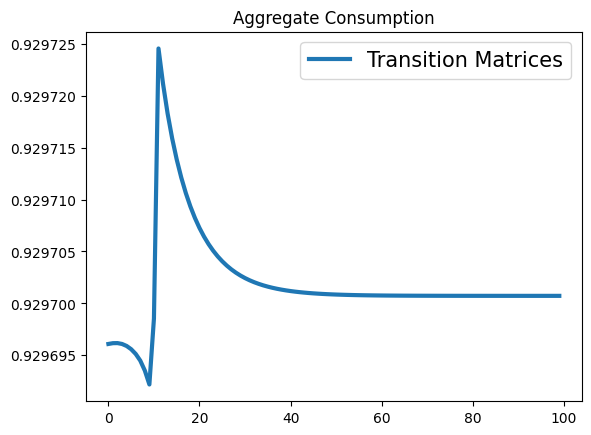

In [37]:
# [ ] label figure with experiment's purpose

plt.plot(
    AggC,
    label = "Transition Matrices",
    linewidth = 3.0,
) 
plt.legend(prop={"size": 15})
plt.title("Aggregate Consumption")
plt.show()

### Path of Aggregate Assets given an anticipated interest rate shock at $t=10$


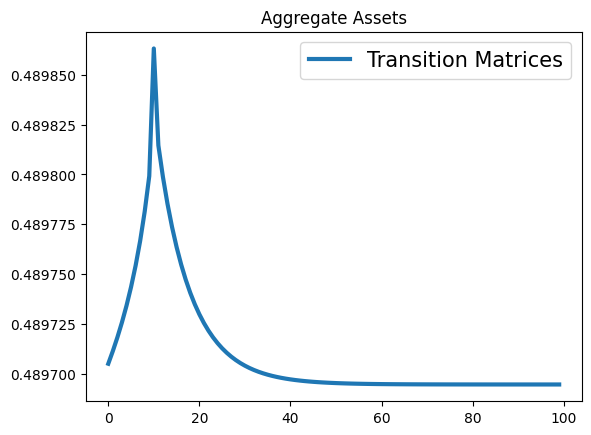

In [38]:
plt.plot(
    AggA,
    label = "Transition Matrices",
    linewidth = 3.0,
) 
plt.legend(prop={"size": 15})
plt.title("Aggregate Assets")
plt.show()

## Jacobians

In [39]:
def compile_JAC(a_ss, c_ss, a_t, c_t, tranmat_ss, tranmat_t, D_ss, C_ss, A_ss, params, Zeroth_col_agent):

    T = params['T_cycle']

    # Expectation vectors
    exp_vecs_a_e = []
    exp_vec_a_e = a_ss
    
    exp_vecs_c_e = []
    exp_vec_c_e = c_ss
    
    for i in range(T):
        
        exp_vecs_a_e.append(exp_vec_a_e)
        exp_vec_a_e = np.dot(tranmat_ss.T, exp_vec_a_e)
        
        exp_vecs_c_e.append(exp_vec_c_e)
        exp_vec_c_e = np.dot(tranmat_ss.T, exp_vec_c_e)
    
    exp_vecs_a_e = np.array(exp_vecs_a_e)
    exp_vecs_c_e = np.array(exp_vecs_c_e)

    da0_s = []
    dc0_s = []

    for i in range(T):
        da0_s.append(a_t[T - i] - a_ss)
        dc0_s.append(c_t[T - i] - c_ss)
    
        
    da0_s = np.array(da0_s)
    dc0_s = np.array(dc0_s)

    dA0_s = []
    dC0_s = []

    for i in range(T):
        dA0_s.append(np.dot(da0_s[i], D_ss))
        dC0_s.append(np.dot(dc0_s[i], D_ss))
    
    dA0_s = np.array(dA0_s)
    A_curl_s = dA0_s/dx
    
    dC0_s = np.array(dC0_s)
    C_curl_s = dC0_s/dx
    
    dlambda0_s = []
    
    for i in range(T):
        dlambda0_s.append(tranmat_t[T - i] - tranmat_ss)
    
    dlambda0_s = np.array(dlambda0_s)
    
    dD0_s = []
    
    for i in range(T):
        dD0_s.append(np.dot(dlambda0_s[i], D_ss))
    
    dD0_s = np.array(dD0_s)
    D_curl_s = dD0_s/dx
    
    Curl_F_A = np.zeros((T , T))
    Curl_F_C = np.zeros((T , T))
    
    # WARNING: SWAPPED THESE LINES TO MAKE DEMO RUN
    # Curl_F_A[0] = A_curl_s
    # Curl_F_C[0] = C_curl_s
    Curl_F_A[0] = A_curl_s.T[0]
    Curl_F_C[0] = C_curl_s.T[0]

    for i in range(T-1):
        for j in range(T):
            Curl_F_A[i + 1][j] = np.dot(exp_vecs_a_e[i], D_curl_s[j])[0]
            Curl_F_C[i + 1][j] = np.dot(exp_vecs_c_e[i], D_curl_s[j])[0]

    J_A = np.zeros((T, T))
    J_C = np.zeros((T, T))

    for t in range(T):
        for s in range(T):
            if (t ==0) or (s==0):
                J_A[t][s] = Curl_F_A[t][s]
                J_C[t][s] = Curl_F_C[t][s]
                
            else:
                J_A[t][s] = J_A[t - 1][s - 1] + Curl_F_A[t][s]
                J_C[t][s] = J_C[t - 1][s - 1] + Curl_F_C[t][s]
     
    # Zeroth Column of the Jacobian
    Zeroth_col_agent.tran_matrix = np.array(Zeroth_col_agent.tran_matrix)
    
    C_t = np.zeros(T)
    A_t = np.zeros(T)
    
    dstn_dot = D_ss
    
    for t in range(T):
        tran_mat_t = Zeroth_col_agent.tran_matrix[t]

        dstn_all = np.dot(tran_mat_t, dstn_dot)

        C = np.dot(c_ss, dstn_all)
        A = np.dot(a_ss, dstn_all)
        
        C_t[t] = C[0]
        A_t[t] = A[0]

        dstn_dot = dstn_all
        
    J_A.T[0] = (A_t - A_ss) / dx
    J_C.T[0] = (C_t - C_ss) / dx

    return J_C, J_A

### Interest Rate Jacobian

In [40]:
JacobianRFreeAgent = MarkovConsumerType(**params)
JacobianRFreeAgent.cycles = 1
JacobianRFreeAgent.IncShkDstn = deepcopy(IncShkDstn)

JacobianRFreeAgent.del_from_time_inv(
    "Rfree",
)  # delete Rfree from time invariant list since it varies overtime
JacobianRFreeAgent.add_to_time_vary("Rfree")

JacobianRFreeAgent.IncShkDstn = params["T_cycle"] * [JacobianRFreeAgent.IncShkDstn[0]]
JacobianRFreeAgent.solution_terminal = deepcopy(agentTM.solution[0])
JacobianRFreeAgent.track_vars = ["cNrm", "pLvl", "aNrm"]

JacobianRFreeAgent.Rfree = (params["T_cycle"] - 1) * [agentTM.Rfree] + [agentTM.Rfree + dx]
JacobianRFreeAgent.solution_terminal = deepcopy(agentTM.solution[0])
JacobianRFreeAgent.solve()

JacobianRFreeAgent.neutral_measure = True
JacobianRFreeAgent.harmenberg_income_process()
JacobianRFreeAgent.define_distribution_grid()

JacobianRFreeAgent.calc_transition_matrix() 

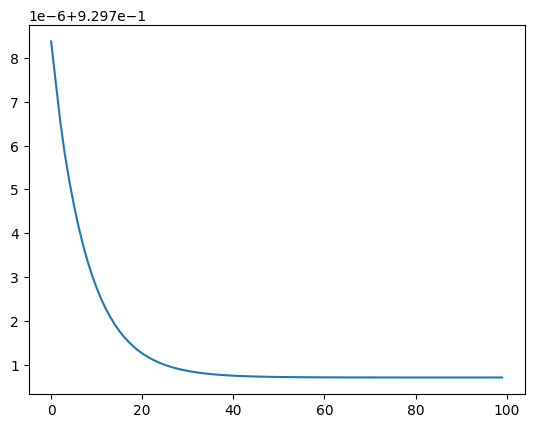

In [41]:
# do a finite horizon simulation with this agent

ZerothColRFreeAgent = MarkovConsumerType(**params)
ZerothColRFreeAgent.cycles = 1
ZerothColRFreeAgent.IncShkDstn = params["T_cycle"] * deepcopy(IncShkDstn)
ZerothColRFreeAgent.solution_terminal = deepcopy(agentTM.solution[0])
ZerothColRFreeAgent.track_vars = ["cNrm", "pLvl", "aNrm"]
ZerothColRFreeAgent.solve()

ZerothColRFreeAgent.neutral_measure = True
ZerothColRFreeAgent.harmenberg_income_process()
ZerothColRFreeAgent.define_distribution_grid()

ZerothColRFreeAgent.Rfree  = [agentTM.Rfree + dx] + (params["T_cycle"] - 1) * [agentTM.Rfree]

ZerothColRFreeAgent.calc_transition_matrix()


T = params["T_cycle"]
ZerothColRFreeAgent.tran_matrix = np.array(ZerothColRFreeAgent.tran_matrix)
    
C_t = np.zeros(T)
A_t = np.zeros(T)
    
dstn_dot = agentTM.vec_erg_dstn
c_ss = agentTM.cPol_Grid.flatten()
a_ss = agentTM.aPol_Grid.flatten()
    
for t in range(T):
    tran_mat_t = ZerothColRFreeAgent.tran_matrix[t]

    dstn_all = np.dot(tran_mat_t, dstn_dot)

    C = np.dot(c_ss, dstn_all)
    A = np.dot(a_ss, dstn_all)
        
    C_t[t] = C[0]
    A_t[t] = A[0]

    dstn_dot = dstn_all

plt.plot(C_t)

In [42]:
D_ss = agentTM.vec_erg_dstn

n_p = 1
n_m = len(JacobianRFreeAgent.MrkvArray[0])
c_ss = agentTM.cPol_Grid.flatten()
a_ss = agentTM.aPol_Grid.flatten()
c_t_unflat = JacobianRFreeAgent.cPol_Grid
a_t_unflat = JacobianRFreeAgent.aPol_Grid

A_ss = agentTM.A_ss
C_ss = agentTM.C_ss
    
transition_matrices = JacobianRFreeAgent.tran_matrix

c_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4 * n_p)))
a_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4 * n_p)))

for t in range(params["T_cycle"]):
    c_t_flat[t] = c_t_unflat[t].flatten()
    a_t_flat[t] = a_t_unflat[t].flatten()

tranmat_ss = agentTM.tran_matrix
tranmat_t = np.insert(transition_matrices, params["T_cycle"], tranmat_ss, axis = 0)

c_t = np.insert( c_t_flat, params["T_cycle"] , c_ss , axis = 0)
a_t = np.insert( a_t_flat, params["T_cycle"] , a_ss , axis = 0)

In [43]:
CJAC_RFree, AJAC_RFree = compile_JAC(a_ss,
                                      c_ss,
                                      a_t,
                                      c_t,
                                      tranmat_ss,
                                      tranmat_t,
                                      D_ss,
                                      C_ss,
                                      A_ss,
                                      params,
                                      ZerothColRFreeAgent)

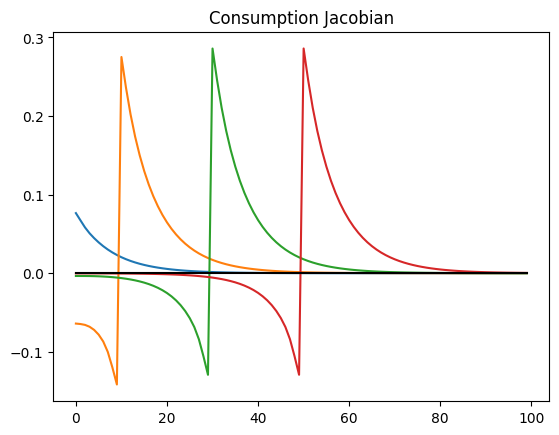

In [44]:
plt.plot(CJAC_RFree.T[0])
plt.plot(CJAC_RFree.T[10])
plt.plot(CJAC_RFree.T[30])
plt.plot(CJAC_RFree.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Consumption Jacobian')
plt.show()

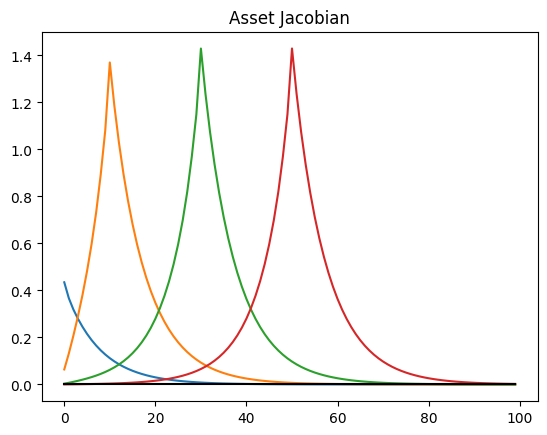

In [45]:
plt.plot(AJAC_RFree.T[0])
plt.plot(AJAC_RFree.T[10])
plt.plot(AJAC_RFree.T[30])
plt.plot(AJAC_RFree.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Asset Jacobian')
plt.show()

### Income Jacobian

In [46]:
IncShkDstn_emp_dx = deepcopy(IncShkDstn_emp)
IncShkDstn_emp_dx.atoms[1] = IncShkDstn_emp_dx.atoms[1] * (1 + dx)    
IncShkDstn_dx = [[IncShkDstn_emp_dx, IncShkDstn_unemp, IncShkDstn_unemp, IncShkDstn_unemp_nb]]

agentTM2 = deepcopy(agentMrkv)
agentTM2.IncShkDstn = deepcopy(IncShkDstn_dx)
agentTM2.neutral_measure = True
agentTM2.harmenberg_income_process()

In [47]:
JacobianIncomeAgent = MarkovConsumerType(**params)
JacobianIncomeAgent.cycles = 1

JacobianIncomeAgent.del_from_time_inv(
    "IncShkDstn",
)
JacobianIncomeAgent.add_to_time_vary("IncShkDstn")

JacobianIncomeAgent.solution_terminal = deepcopy(agentTM.solution[0])
JacobianIncomeAgent.IncShkDstn = (params["T_cycle"] - 1) * deepcopy(IncShkDstn) + deepcopy(IncShkDstn_dx) + deepcopy(IncShkDstn)
JacobianIncomeAgent.dist_pGrid = params["T_cycle"] * [np.array([1])]
JacobianIncomeAgent.solution_terminal = deepcopy(agentTM.solution[0])

JacobianIncomeAgent.solve()

# Calculate Transition Matrices
JacobianIncomeAgent.neutral_measure = True
JacobianIncomeAgent.IncShkDstn = (params["T_cycle"] - 1) * deepcopy(agentTM.IncShkDstn) + \
    deepcopy(agentTM2.IncShkDstn) + deepcopy(IncShkDstn)
JacobianIncomeAgent.define_distribution_grid()
JacobianIncomeAgent.calc_transition_matrix()

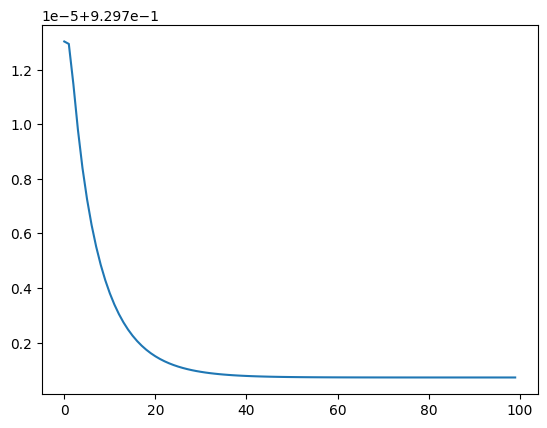

In [53]:
ZerothColIncomeAgent = MarkovConsumerType(**params)
ZerothColIncomeAgent.cycles = 1 
ZerothColIncomeAgent.solution_terminal = deepcopy(agentTM.solution[0])
ZerothColIncomeAgent.IncShkDstn = params["T_cycle"] * deepcopy(IncShkDstn) 
ZerothColIncomeAgent.solve()
ZerothColIncomeAgent.IncShkDstn = deepcopy(agentTM2.IncShkDstn) + (params["T_cycle"]) * deepcopy(agentTM.IncShkDstn)
ZerothColIncomeAgent.neutral_measure = True
ZerothColIncomeAgent.define_distribution_grid()
ZerothColIncomeAgent.calc_transition_matrix()




T = params["T_cycle"]
ZerothColIncomeAgent.tran_matrix = np.array(ZerothColIncomeAgent.tran_matrix)
    
C_t = np.zeros(T)
A_t = np.zeros(T)
    
dstn_dot = agentTM.vec_erg_dstn
c_ss = agentTM.cPol_Grid.flatten()
a_ss = agentTM.aPol_Grid.flatten()
    
for t in range(T):
    tran_mat_t = ZerothColIncomeAgent.tran_matrix[t]

    dstn_all = np.dot(tran_mat_t, dstn_dot)

    C = np.dot(c_ss, dstn_all)
    A = np.dot(a_ss, dstn_all)
        
    C_t[t] = C[0]
    A_t[t] = A[0]

    dstn_dot = dstn_all

plt.plot(C_t)

In [49]:
D_ss = agentTM.vec_erg_dstn

c_ss = agentTM.cPol_Grid.flatten()
a_ss = agentTM.aPol_Grid.flatten()

c_t_unflat = JacobianIncomeAgent.cPol_Grid
a_t_unflat = JacobianIncomeAgent.aPol_Grid

A_ss = agentTM.A_ss
C_ss = agentTM.C_ss
    
transition_matrices = JacobianIncomeAgent.tran_matrix

c_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4)))
a_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4)))

# c_t_flat = np.zeros((params["T_cycle"], params["mCount"], 4))
# a_t_flat = np.zeros((params["T_cycle"], params["mCount"], 4))

for t in range( params["T_cycle"] ):
    c_t_flat[t] = c_t_unflat[t].flatten()
    a_t_flat[t] = a_t_unflat[t].flatten()

tranmat_ss = agentTM.tran_matrix

tranmat_t = np.insert(transition_matrices, params["T_cycle"], tranmat_ss, axis = 0)

c_t = np.insert(c_t_flat, params["T_cycle"] , c_ss , axis = 0)
a_t = np.insert(a_t_flat, params["T_cycle"] , a_ss , axis = 0)

In [50]:
CJAC_Income, AJAC_Income = compile_JAC(a_ss,
                                       c_ss,
                                       a_t,
                                       c_t,
                                       tranmat_ss,
                                       tranmat_t,
                                       D_ss,
                                       C_ss,
                                       A_ss,
                                       params,
                                       ZerothColIncomeAgent)

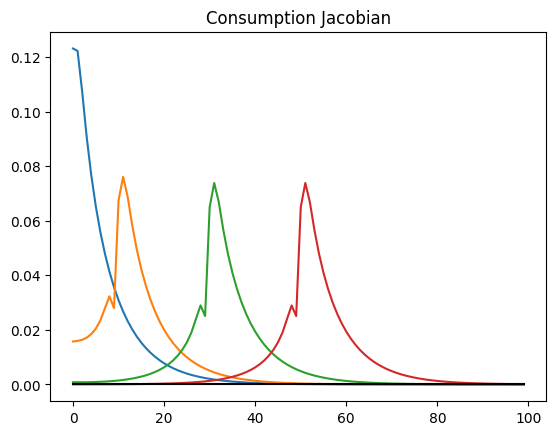

In [51]:
plt.plot(CJAC_Income.T[0])
plt.plot(CJAC_Income.T[10])
plt.plot(CJAC_Income.T[30])
plt.plot(CJAC_Income.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Consumption Jacobian')
plt.show()

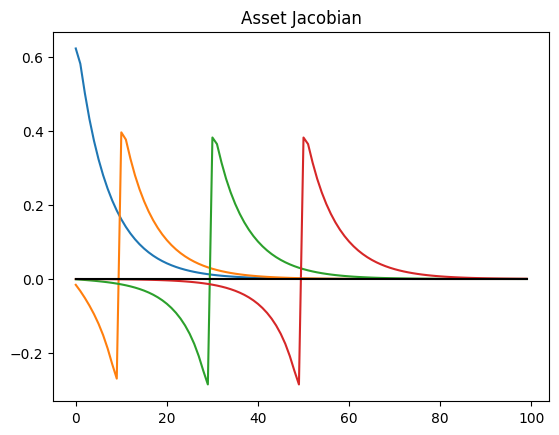

In [52]:
plt.plot(AJAC_Income.T[0])
plt.plot(AJAC_Income.T[10])
plt.plot(AJAC_Income.T[30])
plt.plot(AJAC_Income.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Asset Jacobian')
plt.show()